In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import pandas as pd
import torchvision
from tqdm.notebook import tqdm
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import Normalize
import torchsummary
from torch.optim import lr_scheduler
from pytorch_lightning.callbacks import Callback
import torch.nn as nn
from tempfile import TemporaryDirectory
import time
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
sns.reset_orig()
sns.set()


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard
# Setting the seed

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Create a training dataset

In [2]:
shots = [16534, 16769, 16773, 18057]
shot_df = pd.DataFrame([])
for shot in shots:
    df = pd.read_csv(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/LHmode-detection-shot{shot}.csv')
    shot_df = pd.concat([shot_df, df], axis=0)

df_mode = shot_df['mode'].copy()
df_mode[shot_df['mode']=='L-mode'] = 0
df_mode[shot_df['mode']=='H-mode'] = 1
df_mode[shot_df['mode']=='ELM'] = 2
shot_df['mode'] = df_mode
shot_df = shot_df.reset_index(drop=True) #each shot has its own indexing starting from 0 to 2232

# Precalculated mean and std for each color and each image 
mean, std = pd.read_csv('normalization.csv', index_col=0).values

In [3]:
shot_df[np.logical_and(shot_df['mode']!='L-mode', shot_df['mode']!='H-mode')]


,time,mode,filename
0,950.0,0,imgs/RIS1_16534_t=950.0000000000001.png
1,950.2,0,imgs/RIS1_16534_t=950.2000000000002.png
2,950.4,0,imgs/RIS1_16534_t=950.4000000000001.png
3,950.6,0,imgs/RIS1_16534_t=950.6000000000001.png
4,950.8,0,imgs/RIS1_16534_t=950.8000000000001.png
...,...,...,...
8791,1369.0,0,imgs/RIS1_18057_t=1369.0.png
8792,1369.2,0,imgs/RIS1_18057_t=1369.2000000000003.png
8793,1369.4,0,imgs/RIS1_18057_t=1369.4.png
8794,1369.6,0,imgs/RIS1_18057_t=1369.6000000000001.png


In [4]:
hmodes = shot_df[shot_df['mode']==1]
elms = shot_df[shot_df['mode']==2]
elms

,time,mode,filename
1133,1176.6,2,imgs/RIS1_16534_t=1176.6000000000001.png
1135,1177.0,2,imgs/RIS1_16534_t=1177.0.png
1139,1177.8,2,imgs/RIS1_16534_t=1177.8000000000002.png
1149,1179.8,2,imgs/RIS1_16534_t=1179.8000000000002.png


## TO DO: 
- `reg-ing prev cell`: Do i have to calculate mean and std everytime I add new shot do database?
-  `reg-ing next cell`: I belive images should be normalized with mean=0 and std=1, but they look very strange after denormalization. Mb mean and std where calculated out of small amount of data (2 shots)?
- `general`: Implement TensorBoard!
- `normalization`: There're some artefacts of normalization appearing after `imshow()`.
- `ad normalization`: There's BatchNorm2d in first layer of model. Do I actually need to normalize?

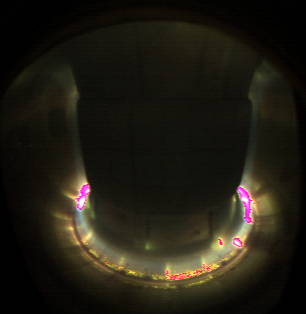 

In [5]:
class ImageDataset(Dataset):
    def __init__(self, annotations, img_dir, mean, std):
        self.img_labels = annotations #pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'filename'])
        image = read_image(img_path).double()
        normalized_image = (image - self.mean[:, None, None])/self.std[:, None, None]
        label = self.img_labels.iloc[idx, 1]
        return image, label #normalized_image, label 
        

    
dataset = ImageDataset(annotations=shot_df[['filename', 'mode']], img_dir='/compass/Shared/Users/bogdanov/vyzkumny_ukol',\
                        mean=mean, std=std)

### TODO: adjust dataset sizes

In [6]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

In [7]:
dataloaders = {'train':train_dataloader, 'val':test_dataloader} #TODO: add test loader in train function and consequenlty to this dict
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

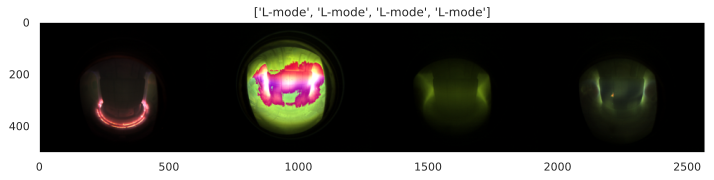

In [8]:
def imshow(inp, mean, std, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,16))
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

modes = ['L-mode', 'H-mode', 'ELM']
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs/255)

imshow(out, mean=mean, std=std, title=[modes[x] for x in classes])

$/\backslash\\$
 | | **Is this image normalization OK?** We also lost some information about pixels singe `torchvision`'s `read_image()` reads originally 4096 bits image as 255 bits

### Searching through dataloader for all 3 modes
Yeah it's a dummy way to test images, but i wanted to test loader, and I kinda enjoyed implementing this

In [9]:
def search_for_LHELM(dataloader):
    for modeind in [0,1,2]:
        lhmodes_and_Elms = next(iter(dataloader))[0][0]
        lhmodes_and_Elms_names = next(iter(dataloader))[1][0]
        
        while modeind not in lhmodes_and_Elms_names:
            inputs, classes = next(iter(dataloader))
            if modeind in classes:
                lhmodes_and_Elms = torch.cat((lhmodes_and_Elms, inputs[np.where(classes==modeind)[0]][0]))
                lhmodes_and_Elms_names = torch.cat((lhmodes_and_Elms_names.view(modeind), torch.tensor([modeind])))
                print(f'{modes[modeind]} was appended to the example')
    return lhmodes_and_Elms, lhmodes_and_Elms_names

#L_H_andelm, L_H_andelm_name = search_for_LHELM(train_dataloader)
# example_out = torchvision.utils.make_grid(L_H_andelm.permute(2,0,1)/255)
#imshow(example_out, mean=mean, std=std, title=[modes[x] for x in classes])

## Playing with TensorBoard

In [10]:
# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/TB_ris_imgs_experiment_3')

# write to tensorboard
writer.add_image('four_compass images', out)

In [11]:
def select_n_random(dataloader, nbatches=25):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    images, labels = next(iter(dataloader))
    for i, batch in enumerate(dataloader):
        image, label = batch
        images = torch.cat((images, image))
        labels = torch.cat((labels, label))
        if i==nbatches:
            break
    return images/255, labels

images, labels = select_n_random(train_dataloader)

In [12]:
# log embeddings
features = images.view(-1, 3*500*640)
writer.add_embedding(features,
                    metadata=[modes[x] for x in labels],
                    label_img=images)
writer.close()

## Import pretrained model


In [ ]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = pretrained_model.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(modes))``.
pretrained_model.fc = torch.nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /run/user/1665/cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 9.58MB/s]


### I will try to freeze all layers except 4-th and fc layer

In [ ]:
# for name, para in pretrained_model.named_parameters():
#     if "layer4" in name or "fc" in name:
#         continue
#     else:
#         para.requires_grad = False

### Alternatively freeze all the weights excepts those of last fc layer

In [ ]:
for param in pretrained_model.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM

In [ ]:
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Here I simply print the structure of model for input with size (3,500,640)

In [ ]:
writer.add_graph(pretrained_model, inputs.float().to(device))


In [ ]:
#torchsummary.summary(pretrained_model, (3,500,640))

In [ ]:
# for name, para in pretrained_model.named_parameters():
#     print("="*40)
#     print(f"name: {name}")
#     print(para)

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
torchvision.utils.make_grid(inputs).size()

torch.Size([3, 504, 2570])

## Tracking model training with TensorBoard

In [ ]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [torch.nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    print('aadsbteoasnfelwkeag s')
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        imshow(images[idx], mean, std,)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## Training
### Training function was copied from [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                i=0 #TODO: eliminate the need in that dummy iterative for tensorboard part
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device).float() #TODO: is it smart to convert double to float here?
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs) #2D tensor with shape Batchsize*len(modes)
                        #TODO: inputs.type. 
                        _, preds = torch.max(outputs, 1) #preds = 1D array of indicies of maximum values in row. ([2,1,2,1,2]) - third feature is largest in first sample, second in second...
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0) #!!! Why is it multiplied by batchsize???
                    running_corrects += torch.sum(preds == labels.data) #How many correct answers
                    i+=1
                    #tensorboard part
                    if i % 1000 == 999:    # every 1000 mini-batches...
                        # ...log the running loss
                        writer.add_scalar('training loss',
                                        running_loss / 1000,
                                        epoch * len(dataloaders[phase]) + i)
                        # ...log a Matplotlib Figure showing the model's predictions on a
                        # random mini-batch
                        writer.add_figure('predictions vs. actuals',
                                        plot_classes_preds(model, inputs, labels),
                                        global_step=epoch * len(dataloaders[phase]) + i)
                        running_loss = 0.0
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Problem with endless output
`imshow()` is not suitable for purpose in line 60 of previous cell

Epoch 0/1
----------
aadsbteoasnfelwkeag s


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

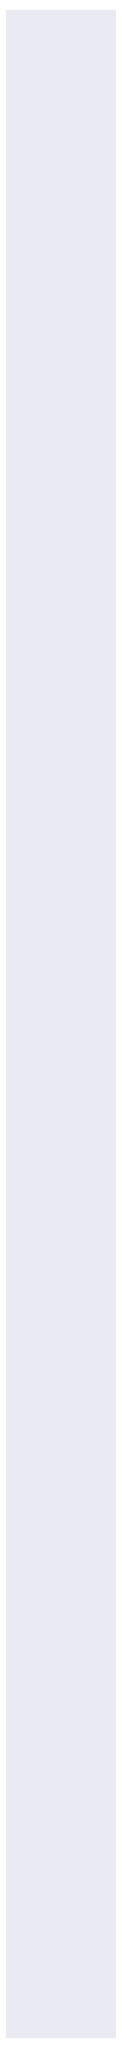

In [ ]:
model = train_model(pretrained_model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=2)